# pset11: the adventure of the 2001 dimensions
*by Xingyu (Luna) Li , Nov 15th, 2021*
  
## Background
There are 2001 neuron-specific sand mouse genes from 8 morphologically distinct cell types.   
Based on 200 single cell RNA-seq experiments, we want to separate those clusters using K-means and PCA.  

## 1. Reproduce Watsons's K-means result
First, we would use the K-means clustering procedure and report the lowest total squared distance (best clustering) we find for K=8.  
Since Watsons used the log transform of the data to perform K-means, we would do the same.    
(I have modified some of my codes according to the example answer from pset05.)

In [1]:
# Import the data
import numpy as np
data = [] ; genes = []
with open("w11-data.tbl") as f:
    for n,line in enumerate(f):
        if n == 0:
            genes = line.split()
        else:
            fields = line.split()
            data.append([int(i) for i in fields])
data  = np.array(data)

# Check the dimensions of our data
print('The dimensions are:  %i x %i' % (data.shape[0], data.shape[1]))

The dimensions are:  200 x 2001


In [2]:
# Log-transform our data so that it is normally distributed
data_log = np.log(data)

# Calculate Euclidean distance
def Euclidean(x1,x2):
    dimension = len(x1)
    dist = 0.0
    for i in range(dimension):
        dist += (x1[i] - x2[i]) ** 2
    return np.sqrt(dist)

# Identify the closest centroid for each data point
def closest_centroid(data, centroids):
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = Euclidean(data, centroids[0])
    for k in range(1,K):
        dist = Euclidean(data, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist

# K-means clustering 
def k_means(data, K):
    
    N, G = np.shape(data)
    
    # Select random centroid for each cluster (choose from X)
    centroids = data[np.random.choice(N, K, replace=False)]

    # iterate until the assignments of each item to the clusters do not change
    iteration = 0
    while True:
        
        #  Assignment according to the closest centroid for each data point
        assignments = np.zeros(N).astype(int)
        tot_sqdist  = 0
        for i,x in enumerate(data):
            assignments[i], di = closest_centroid(x, centroids)
            tot_sqdist += di**2
        
        # Check if the assignments change
        ndiff = 0
        if iteration >= 1:
            for i in range(N):
                if assignments[i] != old_assignments[i]: 
                    ndiff += 1
            if ndiff == 0: 
                break
        
        # Calculate new centroid positions and given assignments of data points to centroids
        centroids = np.zeros((K,G))        
        counts    = np.zeros(K)
        for i in range(N):
            counts[assignments[i]] += 1
            for g in range(G):
                centroids[assignments[i], g] += data[i][g]
        for k in range(K):
            if counts[k] > 0:                                      # reinitialize
                centroids[k] = np.divide(centroids[k], counts[k])  # to aviod a centroid gets no assigned points
            else:                                                  
                centroids[k] = sample_component(X)
        Z = np.sum(counts)
        counts = np.divide(counts, Z)
        old_assignments = assignments
        iteration += 1
    
    # Calculate the probability mass (# of data points) assigned to component k
    C = np.zeros(K)
    for i in range(N):
        C[assignments[i]] += 1
    C = np.divide(C, N)
    
    return C, assignments, centroids, tot_sqdist

# Find the lowest total squared distance and return the result
def lowest_sqdist(data, times):
    tot_sqdist_list = []  # initialize the lists
    labels_list = []
    centroids_list = []
    for i in range(times): # add each result to the list
        C, labels, centroids, tot_sqdist = k_means(data, 8)
        tot_sqdist_list.append(tot_sqdist)
        labels_list.append(labels)
        centroids_list.append(centroids)
    # Choose the clustering result with the lowest total squared distance
    labels = labels_list[np.argmin(tot_sqdist_list)]
    centroids = centroids_list[np.argmin(tot_sqdist_list)]
    return labels,centroids,min(tot_sqdist_list)

times = 30
np.random.seed(9)
labels,centroids,tot_sqdist = lowest_sqdist(data = data_log, times = times)
print("The lowest total squared distance for {} iterations is {}.".format(times, tot_sqdist))

The lowest total squared distance for 30 iterations is 87446.37093912183.


It turns out that our lowest total squared distance for 30 iterations is close to Watsons's 87378.2.  
  
## 2. Reduce the dimensionality
Next, we are going to use singular value decomposition to find the principal components of the data set.

In [3]:
# Center our data matrix
data_centered = data_log - np.mean(data_log,axis = 0)

# Perform singular value decomposition
u, s, wt = np.linalg.svd(data_centered)
w = wt.T
w.shape

(2001, 2001)

Here, W is a 2001 × 2001 matrix whose columns correspond to each eigenvector, w1...2001.

In [4]:
# Calculate the PC scores with the first 2 eigenvectors
y2 = data_centered @ w[:,:2]
y2

array([[ 5.45032126,  2.87017714],
       [ 5.84123856,  1.96032805],
       [-4.7830636 ,  1.97567779],
       [-1.98425294, -3.77022154],
       [-3.28618672, -3.69350777],
       [-4.14604974,  1.98038337],
       [ 7.55135141, -0.85099023],
       [-5.17294206,  3.04797302],
       [-2.33187865, -3.84781352],
       [ 3.49853317, -0.55910782],
       [-4.6679954 ,  2.94756301],
       [ 4.47749882,  1.99998381],
       [-2.81931605, -3.69738941],
       [-3.1368851 , -4.30266782],
       [-4.41780331, -5.38604191],
       [ 4.3246999 ,  2.2537816 ],
       [-3.3973561 , -3.89782907],
       [ 0.90700153, -3.80844696],
       [ 2.27769482, -1.36824405],
       [ 3.37773442, -1.02659242],
       [-0.53413343, -4.22957729],
       [-2.04814321, -4.24464198],
       [-3.12225911, -3.80434221],
       [-3.41320378, -3.67578751],
       [ 7.9514642 , -0.36377425],
       [ 2.4530363 , -1.13392996],
       [-2.22548775, -0.66433384],
       [-3.56632482,  7.4499901 ],
       [-2.13890834,

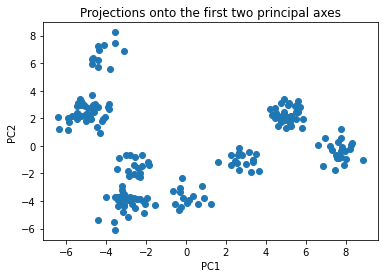

In [5]:
# Plot the projections onto the first two principal axes
import matplotlib.pyplot as plt
plt.scatter(y2[:,0],y2[:,1])
plt.title("Projections onto the first two principal axes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

After singular value decomposition, there seems to be 8 clusters shown in the first two principal axes, which is consistent with Watsons's claim.   
  
Next, we want to compute the eigenvalues for each component to see if there is more information left in the remaining PCs.

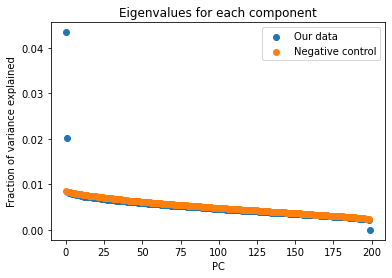

In [6]:
# Calculate the eigenvalues
Lambda = (s**2)/(data.shape[0]-1)

# The fraction of variance captured by each PC
frac = Lambda / np.sum(Lambda)

# Compare to the eigenvalues for the negative control
neg = []
with open("w11-eigen.tbl") as f:
    for n,line in enumerate(f):
        fields = line.split()
        neg.append(float(fields[1]))
neg = neg / np.sum(neg)

# Plot the fraction of variance explained for each component
plt.scatter(range(len(frac)), frac, label = "Our data")
plt.scatter(range(len(neg)), neg, label = "Negative control")
plt.title("Eigenvalues for each component")
plt.legend()
plt.xlabel("PC")
plt.ylabel("Fraction of variance explained")
plt.show()

In [7]:
# Find the eigenvalues that are higher than negative control
for i in range(len(frac)):
    if frac[i] < neg[i]:
        break
q = i # number of signal PCs
print("q: ", q)

q:  2


Since there are no cell types and no correlations between any of the genes in the negative control data, the eigenvalues of it would be simply noise.   
By plotting with our data together, we can see that only our first two principal components contain useful information about the clusters and we are pretty sure that those two PCs are sufficient for our analysis.  

In the following step, we would like to find the most important genes by their PC loadings.

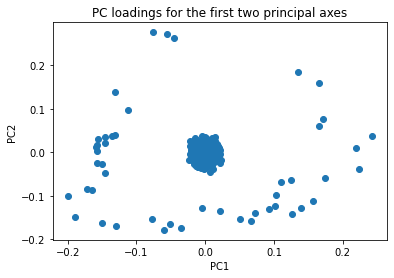

In [8]:
# PC loadings for the first 2 eigenvectors
plt.scatter(w[:,0],w[:,1])
plt.title("PC loadings for the first two principal axes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

We can see that genes that aren't contributing much variance along a principal axis fall near the origin, while those do contribute fall away from the axis.  
Therefore, we could set a threshold of ± 0.1 for each PC to filter out the important genes for clustering.

In [9]:
# Filter the important genes with |PC1| or |PC2| > 0.1 
idx = np.array(np.where((np.abs(w[:,0])>0.1)| (np.abs(w[:,1])>0.1))).flatten() # index of those genes
ni = len(idx) # number of important genes
important = []
for i in range(ni):
    important.append(genes[i])
print("There are {} important genes: \n {}".format(ni,important))

There are 47 important genes: 
 ['arugula', 'blueberry', 'cabbage', 'chickpea', 'clementine', 'cranberry', 'honeydew', 'mulberry', 'mustard', 'onion', 'pear', 'plum', 'sage', 'strawberry', 'PERM1', 'ATAD3C', 'ATAD3B', 'PLCH2', 'SMIM1', 'RNF207', 'PLEKHG5', 'ZBTB48', 'TMEM201', 'FBXO44', 'MAD2L2', 'PRAMEF11', 'PRAMEF9', 'DDI2', 'TMEM82', 'FBXO42', 'PADI6', 'AKR7A3', 'HTR6', 'TMCO4', 'PLA2G2E', 'PLA2G2D', 'VWA5B1', 'CDA', 'PINK1', 'CELA3B', 'EPHB2', 'RPL11', 'HMGCL', 'RSRP1', 'TMEM50A', 'RP11-96L14.7', 'AIM1L']


## 3. Check the K
Since we have clustered our data using K-means in Q1, we want to plot them in 2D principal component space and compare the results from K-means and PCA.  

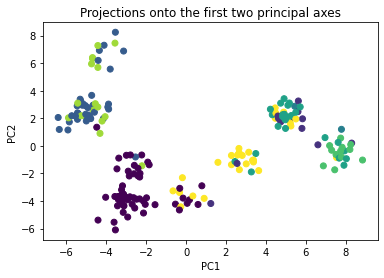

In [10]:
# Visualize the K-means clustering results
plt.scatter(y2[:,0],y2[:,1],c=labels)
plt.title("Projections onto the first two principal axes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

We can see that K-means don't work well on several points, assigning them to different clusters when they appear to cluster together in our projection plot.   
A possible reason behind this is that there are too much noise within our dataset, and we can evalute it by calculating the fraction of variance for only the first two PCs.

In [11]:
# Calculate the variance in our data
noise = 1 - np.sum(frac[0:2])/np.sum(frac)
print("There are {0:.3%} variance from noise in the dataset.".format(noise))

There are 93.645% variance from noise in the dataset.


Another useful way of looking at variance explained, since we will always keep the first q PCs, is to examine how much of the total variance is explained as we keep more and more PCs:

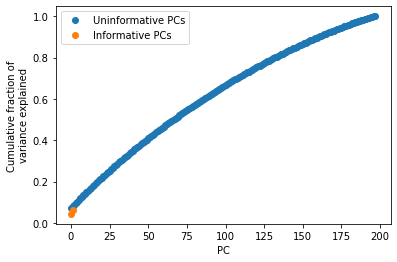

In [12]:
# Cumulative variance explained by q PCs
cum = np.cumsum(frac)

plt.plot(range(len(cum[q:])), cum[q:], 'o', label = "Uninformative PCs")
plt.plot(range(len(cum[:q])), cum[:q], 'o', label = "Informative PCs")
plt.legend()
plt.xlabel('PC'); plt.ylabel('Cumulative fraction of\nvariance explained')
plt.show()

It turns out the majority of variance comes from other PCs, these noises will interfere with the clustering ability of K-means, leading to inaccurate results.   
Therefore, a feasible solution is to use the de-noising data for k-means training, that is, the data projection of PC1 and PC2.

In [13]:
# Use the PC1 and PC2 projections to perform k-means
times = 30
np.random.seed(99)
labels,centroids,tot_sqdist = lowest_sqdist(data = y2, times = times)
print("The lowest total squared distance for {} iterations is {}.".format(times, tot_sqdist))

The lowest total squared distance for 30 iterations is 130.56501825299577.


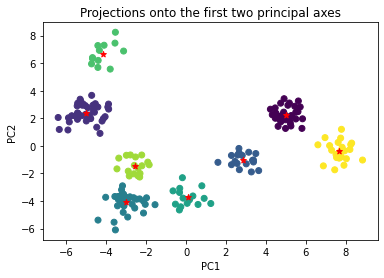

In [14]:
# Visualize the K-means clustering results
plt.scatter(y2[:,0],y2[:,1],c=labels)
plt.scatter(centroids[:,0],centroids[:,1], marker='*', color = "red")
plt.title("Projections onto the first two principal axes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Using the PC1 and PC2 projections to perform k-means, we can see that each cell appears properly assigned in PC space in our plot.  
  
## 4. Reconstruct the expression patterns
Finally, we are going to reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal components.

In [15]:
# Reconstruct the data using the first 2 PCs
x2 = y2 @ wt[0:2,:]
x2.shape

(200, 2001)

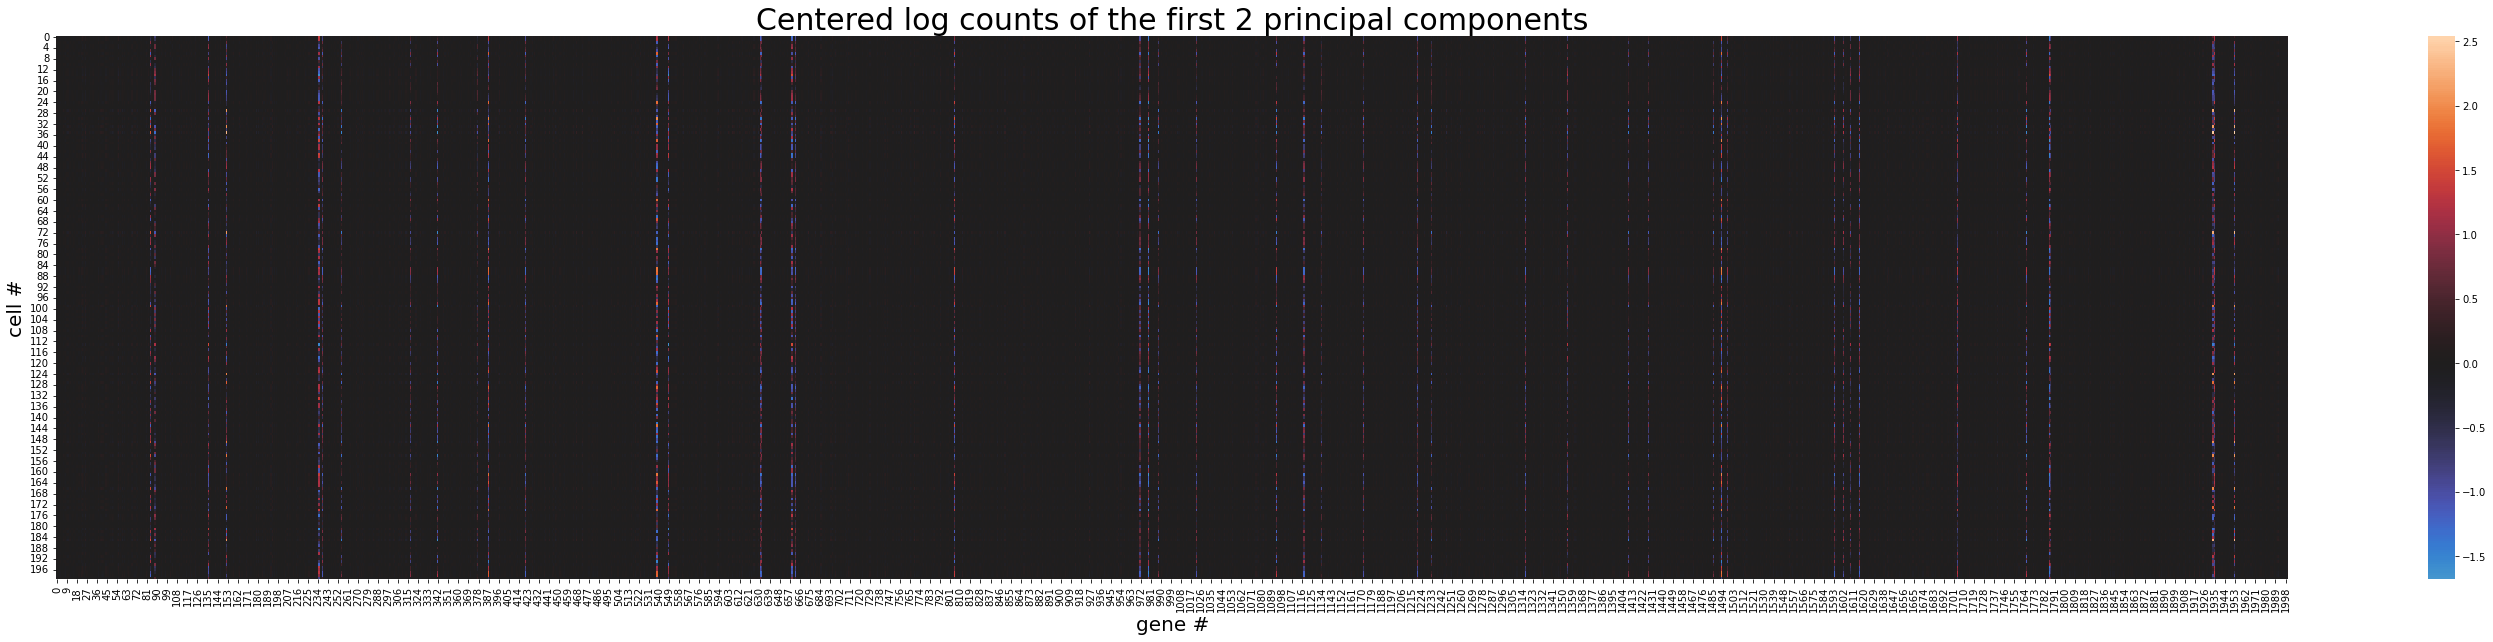

In [16]:
# Visualize the data using a heat map
import seaborn as sns
plt.figure(figsize=(50,10))
sns.heatmap(x2, center=0)
plt.xlabel('gene #', fontsize = 20)
plt.ylabel('cell #', fontsize = 20)
plt.title('Centered log counts of the first 2 principal components', fontsize = 30)
plt.show()

There's clearly some pattern for those cells, we can sort them according to their labels for better visualization.

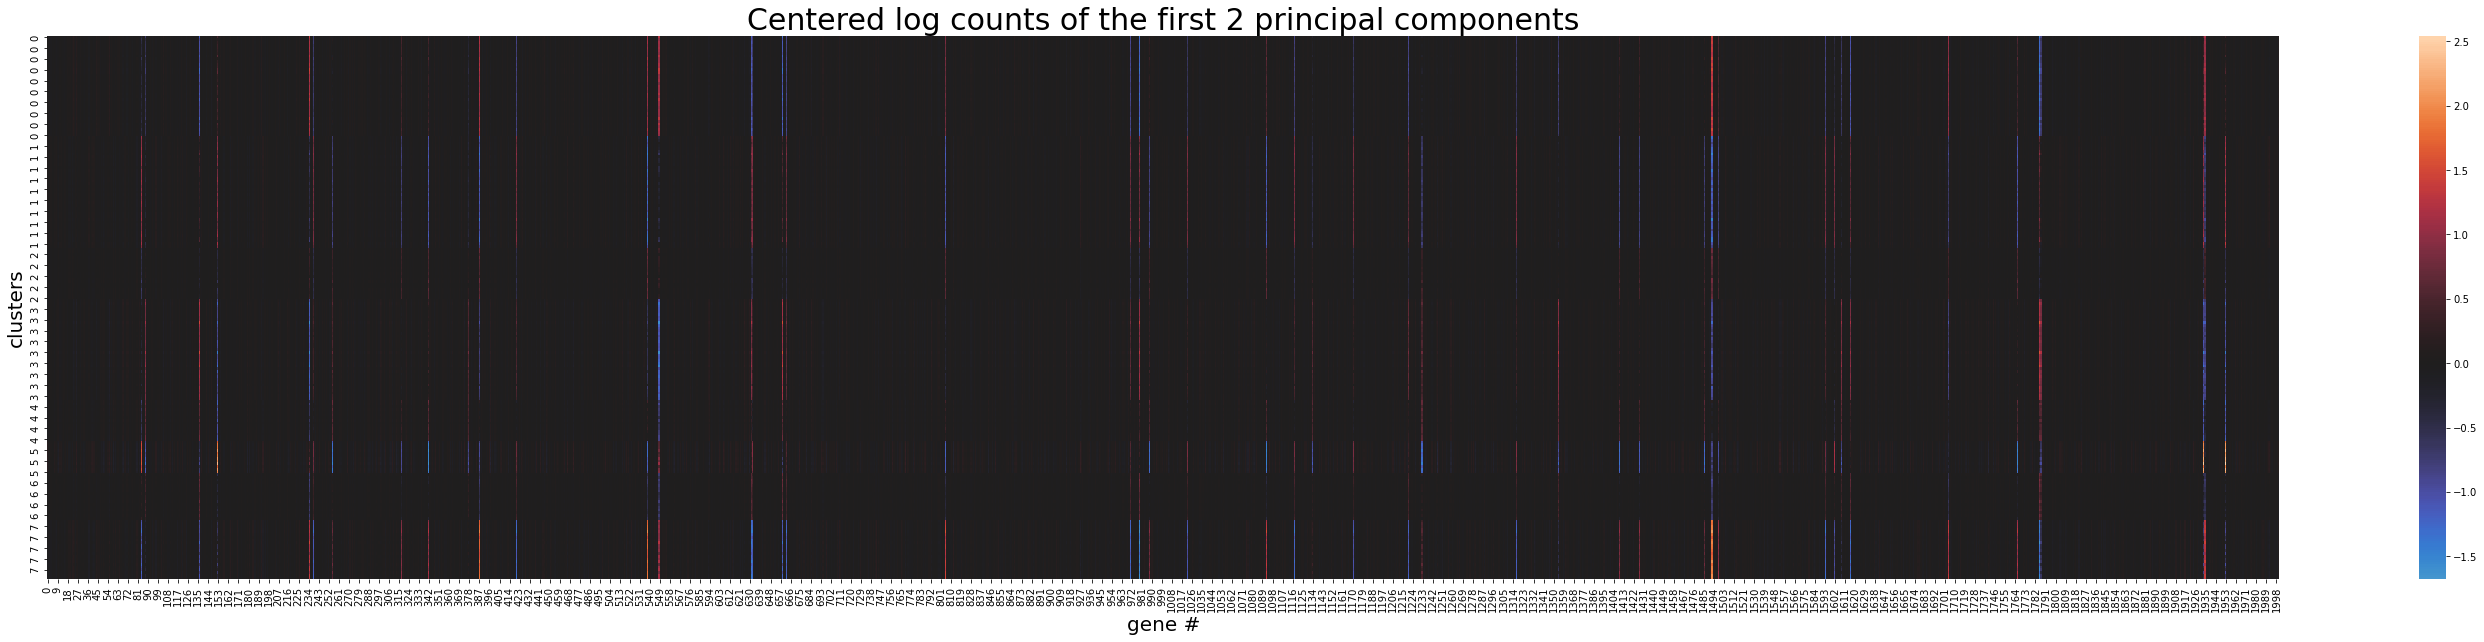

In [17]:
# Sort the data according to their cluster labels
import pandas as pd
x2_df = pd.DataFrame(x2,index = labels) # convert to pandas dataframe
x2_sorted = x2_df.sort_index(axis = 0)  # sort the data according to labels

# Visualize the data
plt.figure(figsize=(50,10))
sns.heatmap(x2_sorted, center=0)
plt.xlabel('gene #', fontsize = 20)
plt.ylabel('clusters', fontsize = 20)
plt.title('Centered log counts of the first 2 principal components', fontsize = 30)
plt.show()

Since there are too many genes but only several of them are meaningful to cluster the cells, we can only plot the heatmap of them for a better visualization of the clusters.

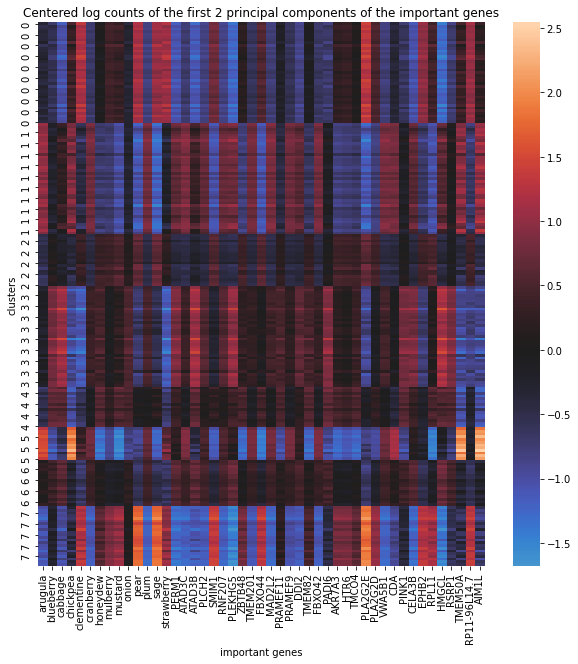

In [18]:
# Visualize only those 'important' genes
x2_important = x2_sorted.iloc[:,idx]
plt.figure(figsize=(10,10))
sns.heatmap(x2_important, center=0, xticklabels = important)
plt.xlabel('important genes')
plt.ylabel('clusters')
plt.title('Centered log counts of the first 2 principal components of the important genes')
plt.show()

After reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal components, we can see that gene expression level shows distinct patterns for each cluster.   
It turns out that Watsons was right about the 8 morphologically distinct cell types according to our PCA and k-means analysis.